# VRP Demo with SCIP
This file is intended to build the model for the CVRP using SCIP

In [1]:
from pyscipopt import Model, Pricer, SCIP_RESULT, SCIP_STAGE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import sys

from cffi import FFI
ffi = FFI()
labelling_lib = ffi.dlopen("Labelling/labelling_lib.so")

funDefs = "void initGraph(unsigned num_nodes, unsigned* node_data, double* edge_data, const double capacity); void labelling(double const * dual,const bool farkas, unsigned* result);"
ffi.cdef(funDefs, override=True)

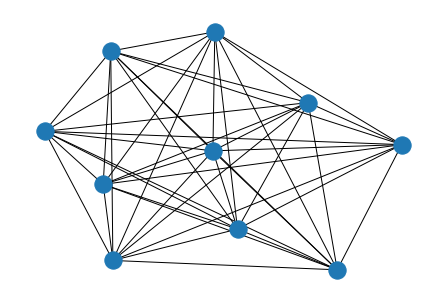

In [2]:
# Create Graph
G = nx.complete_graph(10)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(1,10)
    
for node in G.nodes():
    G.nodes()[node]['demand'] = random.randint(1,10)

nx.draw(G)

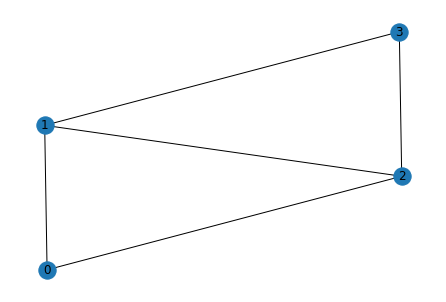

In [28]:
# Create Simple Graph for correctnes
G = nx.complete_graph(4)
G.remove_edge(0,3)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1
G.edges[1,2]['weight'] = 1

for node in G.nodes():
    G.nodes()[node]['demand'] = 2

nx.draw(G,with_labels=True)

In [2]:
# Test instance E-n22-k4 provided by parser
G = nx.read_gml("test.gml")

In [3]:
class VRP(Model):
    def __init__(self,graph):
        super().__init__()
        
        self.original_graph = graph
        self.graph = graph.copy()
        self.vars = {}
        self.cons = []

In [24]:
class VRPPricer(Pricer): 
    def pricerinit(self):
        self.data['cons'] = [self.model.getTransformedCons(con) for con in self.model.cons]
        self.data['vars'] = {path:self.model.getTransformedVar(var) for (path,var) in self.model.vars.items()}
        
        print(f" There are {len(self.model.getConss())} constraints in the model and {len(self.data['cons'])} of them are known to the pricer.")
        
        node_data = list(nx.get_node_attributes(self.model.graph,"demand").values())
        if not np.all(np.array(node_data)):
           print("PRICER_PY: The demands of all nodes must be > 0.")
        print(f"PRICER_PY: The demands are {node_data}")
        nodes_arr = ffi.cast("unsigned*", np.array(node_data).astype(np.uintc).ctypes.data)

        edges = nx.adjacency_matrix(self.model.graph,dtype=np.double).toarray()
        edges_arr = ffi.cast("double*", edges.ctypes.data)
        
        num_nodes = ffi.cast("unsigned",self.model.graph.number_of_nodes())
        
        capacity_ptr = ffi.cast("double",self.data['capacity'])
        labelling_lib.initGraph(num_nodes,nodes_arr,edges_arr, capacity_ptr)
    
    def pricerfarkas(self):
        dual = [self.model.getDualfarkasLinear(con) for con in self.data['cons']]
#         print(f"PRICER_PY: Farkas Values are {dual}")
        return self.labelling(dual, farkas=True)

    def pricerredcost(self):
        dual = [self.model.getDualsolLinear(con) for con in self.data['cons']]
#         print(f"PRICER_PY: Dual variables are {dual}")
        return self.labelling(dual)
    
    def labelling(self, dual,farkas=False):
        pointer_dual = ffi.cast("double*", np.array(dual,dtype=np.double).ctypes.data)
        
        # Should be capacity + 2, but I gave it a little more room
        # TODO: Possible improvement: result can be reused every time
        result = np.zeros(self.data['capacity'] + 10,dtype=np.uintc)
        result_arr = ffi.cast("unsigned*",result.ctypes.data)
        
        labelling_lib.labelling(pointer_dual, farkas,result_arr)
        
        if(result[0] == 1):
#             print("There are no paths with negative reduced costs")
            return {'result':SCIP_RESULT.SUCCESS}
        
        result_indices = np.insert(np.nonzero(result),0,0)
        path = tuple(result[result_indices])
        if path in self.data['vars'].keys():
            cost = self.model.getVarRedcost(self.data['vars'][path])
            if farkas:
                print(f"PY Farkaspricing: Path already exists. | {path}")
            else:
                print(f"PY Pricing: Path already exists. Reduced Cost {cost:.2f} | {path}")
            return {'result':SCIP_RESULT.SUCCESS}
        
        var = self.model.addVar(vtype="I",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
        weight = nx.path_weight(self.model.graph,path,"weight")
#         print(f"Added {path} with path weight {weight}")
        counts = np.unique(path[1:-1], return_counts=True)
        for i, node in enumerate(counts[0]):
            self.model.addConsCoeff(self.data['cons'][node-1], var ,counts[1][i])

        self.model.addConsCoeff(self.data['cons'][-1], var, 1)
        self.data['vars'][tuple(path)] = var
        
        return {'result':SCIP_RESULT.SUCCESS}

In [25]:
model = VRP(G)
num_vehicles = 30

# Create pricer
pricer = VRPPricer()
pricer.data = {}
pricer.data["capacity"] = 40
pricer.data["num_vehicles"] = num_vehicles
model.includePricer(pricer, "pricer","does pricing")

# Create a valid set of variables and the constraints to it
for i in range(1,G.number_of_nodes()-1):
    #TODO: I should check, whether these paths are indeed feasible.
    path = (0,i,G.number_of_nodes()-1)
    cost = nx.path_weight(G,path,"weight")
    var = model.addVar(vtype="I",obj=cost)
    model.vars[path] = var
    cons = model.addCons(var == 1, name=str(node),modifiable=True)
    model.cons.append(cons)
    
# Add the convexity constraint, which limits the number of available vehicles
convexity_constraint = model.addCons(sum(model.vars.values()) <= num_vehicles, modifiable=True)
model.cons.append(convexity_constraint)

# model.hideOutput()
model.optimize()
model.hideOutput(quiet=False)
# model.printBestSol()
sol = model.getBestSol()

# Flushing should probably prevent the console output from SCIP mix up with the following print
sys.stdout.flush()
print("\n\nThe solution contains the following paths: ")
for path, var in pricer.data['vars'].items():
    if sol[var] > 0.5:
        print(f"{var}: {path}")


 There are 9 constraints in the model and 9 of them are known to the pricer.
PRICER_PY: The demands are [6, 2, 4, 1, 6, 5, 3, 3, 4, 7]
PRICER_C: Graph data successfully copied to C.
presolving:
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 8 variables (0 bin, 8 int, 0 impl, 0 cont) and 9 constraints
      9 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
p 0.0s|     1 |     0 |     0 |     - |shiftand|   0 |   8 |   9 |   9 |   0 |  0 |   0 |   0 |      --      | 9.500000e+01 |    Inf | unknown
  0.0s|     1 |     0 |     9 |     - |   628k |   0 |   9 |   9 |   9 |   0 |  0 |   0 |   0 |      --      | 9.500000e+01 |    Inf | unknown
  0.1s|     1 | 

PY Pricing: Path already exists. Reduced Cost -7.98 | (0, 6, 2, 4, 2, 4, 2, 4, 2, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -48.40 | (0, 5, 2, 4, 2, 4, 2, 4, 2, 3, 9)
PY Pricing: Path already exists. Reduced Cost -50.00 | (0, 5, 2, 4, 2, 4, 2, 4, 2, 3, 9)
PY Pricing: Path already exists. Reduced Cost -49.89 | (0, 5, 2, 4, 2, 4, 2, 4, 2, 3, 9)
PY Pricing: Path already exists. Reduced Cost -7.40 | (0, 6, 2, 4, 2, 4, 2, 4, 2, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -27.63 | (0, 5, 2, 4, 2, 4, 2, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -11.28 | (0, 6, 2, 8, 2, 8, 2, 8, 2, 4, 7, 9)
PY Pricing: Path already exists. Reduced Cost 4.80 | (0, 6, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost 3.40 | (0, 6, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -16.48 | (0, 6, 2, 4, 2, 4, 2, 4, 2, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -14.10 | (0, 3, 1, 2, 4, 2, 

PY Pricing: Path already exists. Reduced Cost -0.00 | (0, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 9)
PY Pricing: Path already exists. Reduced Cost 21.99 | (0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 7, 9)
PY Pricing: Path already exists. Reduced Cost -23.38 | (0, 2, 4, 2, 4, 2, 4, 2, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -64.71 | (0, 3, 2, 4, 2, 4, 2, 4, 2, 3, 6, 3, 9)
PY Pricing: Path already exists. Reduced Cost 4.05 | (0, 6, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -3.73 | (0, 6, 8, 2, 8, 2, 8, 2, 8, 1, 3, 1, 3, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -3.37 | (0, 6, 8, 2, 8, 2, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -2.73 | (0, 6, 8, 2, 8, 2, 8, 2, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -3.45 | (0, 6, 8, 2, 8, 2, 8, 2, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -2.00 | (0, 6, 8, 2, 8, 2,

PY Pricing: Path already exists. Reduced Cost -49.69 | (0, 7, 4, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -52.20 | (0, 7, 4, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -1.54 | (0, 3, 7, 3, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -56.42 | (0, 7, 4, 7, 4, 7, 4, 2, 4, 7, 9)
PY Pricing: Path already exists. Reduced Cost -22.50 | (0, 7, 4, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -22.73 | (0, 7, 4, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -54.01 | (0, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 3, 9)
PY Farkaspricing: Path already exists. | (0, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost 2.87 | (0, 6, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost 2.83 | (0, 6, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 

PY Pricing: Path already exists. Reduced Cost -82.00 | (0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 2, 3, 9)
PY Pricing: Path already exists. Reduced Cost -91.40 | (0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 2, 3, 9)
PY Pricing: Path already exists. Reduced Cost -68.91 | (0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 2, 3, 9)
PY Pricing: Path already exists. Reduced Cost -89.92 | (0, 6, 5, 6, 5, 6, 5, 6, 5, 6, 2, 3, 9)
PY Farkaspricing: Path already exists. | (0, 5, 3, 5, 3, 5, 3, 5, 3, 5, 8, 5, 3, 9)
PY Pricing: Path already exists. Reduced Cost -8.45 | (0, 8, 2, 8, 2, 8, 2, 8, 2, 8, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -75.68 | (0, 4, 2, 4, 2, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -952.17 | (0, 7, 4, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Farkaspricing: Path already exists. | (0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 8, 9)
PY Farkaspricing: Path already exists. | (0, 7, 4, 7, 4, 7, 4, 7, 4, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -0.73 | (0, 3, 1, 3, 1, 8, 2, 8, 2, 8, 2, 8, 1, 3, 7, 9)
P

PY Pricing: Path already exists. Reduced Cost -34.47 | (0, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 9)
PY Pricing: Path already exists. Reduced Cost -31.34 | (0, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -36.16 | (0, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -40.92 | (0, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -39.51 | (0, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 9)
PY Pricing: Path already exists. Reduced Cost -0.21 | (0, 6, 5, 4, 2, 8, 2, 8, 1, 3, 1, 3, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -0.91 | (0, 6, 5, 4, 5, 4, 5, 4, 1, 3, 9)
PY Pricing: Path already exists. Reduced Cost -2.32 | (0, 6, 5, 4, 1, 3, 1, 3, 1, 4, 5, 4, 9)
PY Pricing: Path already exists. Reduced Cost -1.00 | (0, 6, 5, 4, 5, 4, 5, 4, 1, 3, 9)
  1.2s|  1000 |     


SCIP Status        : problem is solved [optimal solution found]
Solving Time (sec) : 1.41
Solving Nodes      : 1139
Primal Bound       : +6.70000000000000e+01 (2 solutions)
Dual Bound         : +6.70000000000000e+01
Gap                : 0.00 %


The solution contains the following paths: 
t_x1: (0, 1, 9)
t_x2: (0, 2, 9)
t_x3: (0, 3, 9)
t_x8: (0, 8, 9)
x97: (0, 6, 5, 4, 7, 9)


## Old Labelling

In [ ]:

    def simple_labeling(self,dual,farkas=False):
        for path in nx.all_simple_paths(self.model.graph,0,list(G.nodes())[-1]):
            if tuple(path) not in self.data['vars'].keys():
                if farkas:
                    weight = 0
                else:
                    weight = nx.path_weight(self.model.graph,path,"weight")
                load = 0
                
                for node in path[1:-1]:
                    weight -= dual[node-1]
                    load += self.model.graph.nodes()[node]['demand']
                if weight < 0 and load <= self.data['capacity']:
                    var = self.model.addVar(vtype="B",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
                    for node in path[1:-1]:
                        self.model.addConsCoeff(self.data['cons'][node-1], var ,1)
                    
                    self.model.addConsCoeff(self.data['cons'][-1], var, 1)
                    self.data['vars'][tuple(path)] = var
#                     print(f"Found path {path} with negative reduced cost")
                    return {'result':SCIP_RESULT.SUCCESS}
        return {'result':SCIP_RESULT.SUCCESS}